# Loading from Zarr

<br>

### Imports

In [3]:
from satip import reproj

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os

<br>

### User Inputs

We have to specify the directory where the data native filepaths are located

In [ ]:
data_dir = '../data/raw'

<br>

### Loading the Scene

We'll then load the file using the reproj library

In [11]:
native_fps = sorted([f'{data_dir}/{f}' for f in os.listdir(data_dir) if '.nat' in f])
native_fp = native_fps[0]

scene = reproj.load_scene(native_fp)
scene.load(['HRV'])

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<br>

Next we'll visualise the data in the HRV layer. 

In this particular image it looks like we've caught a period where the satellite is slightly off-kilter. Fortunately the area definition we create accounts for periods when this occurs.

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


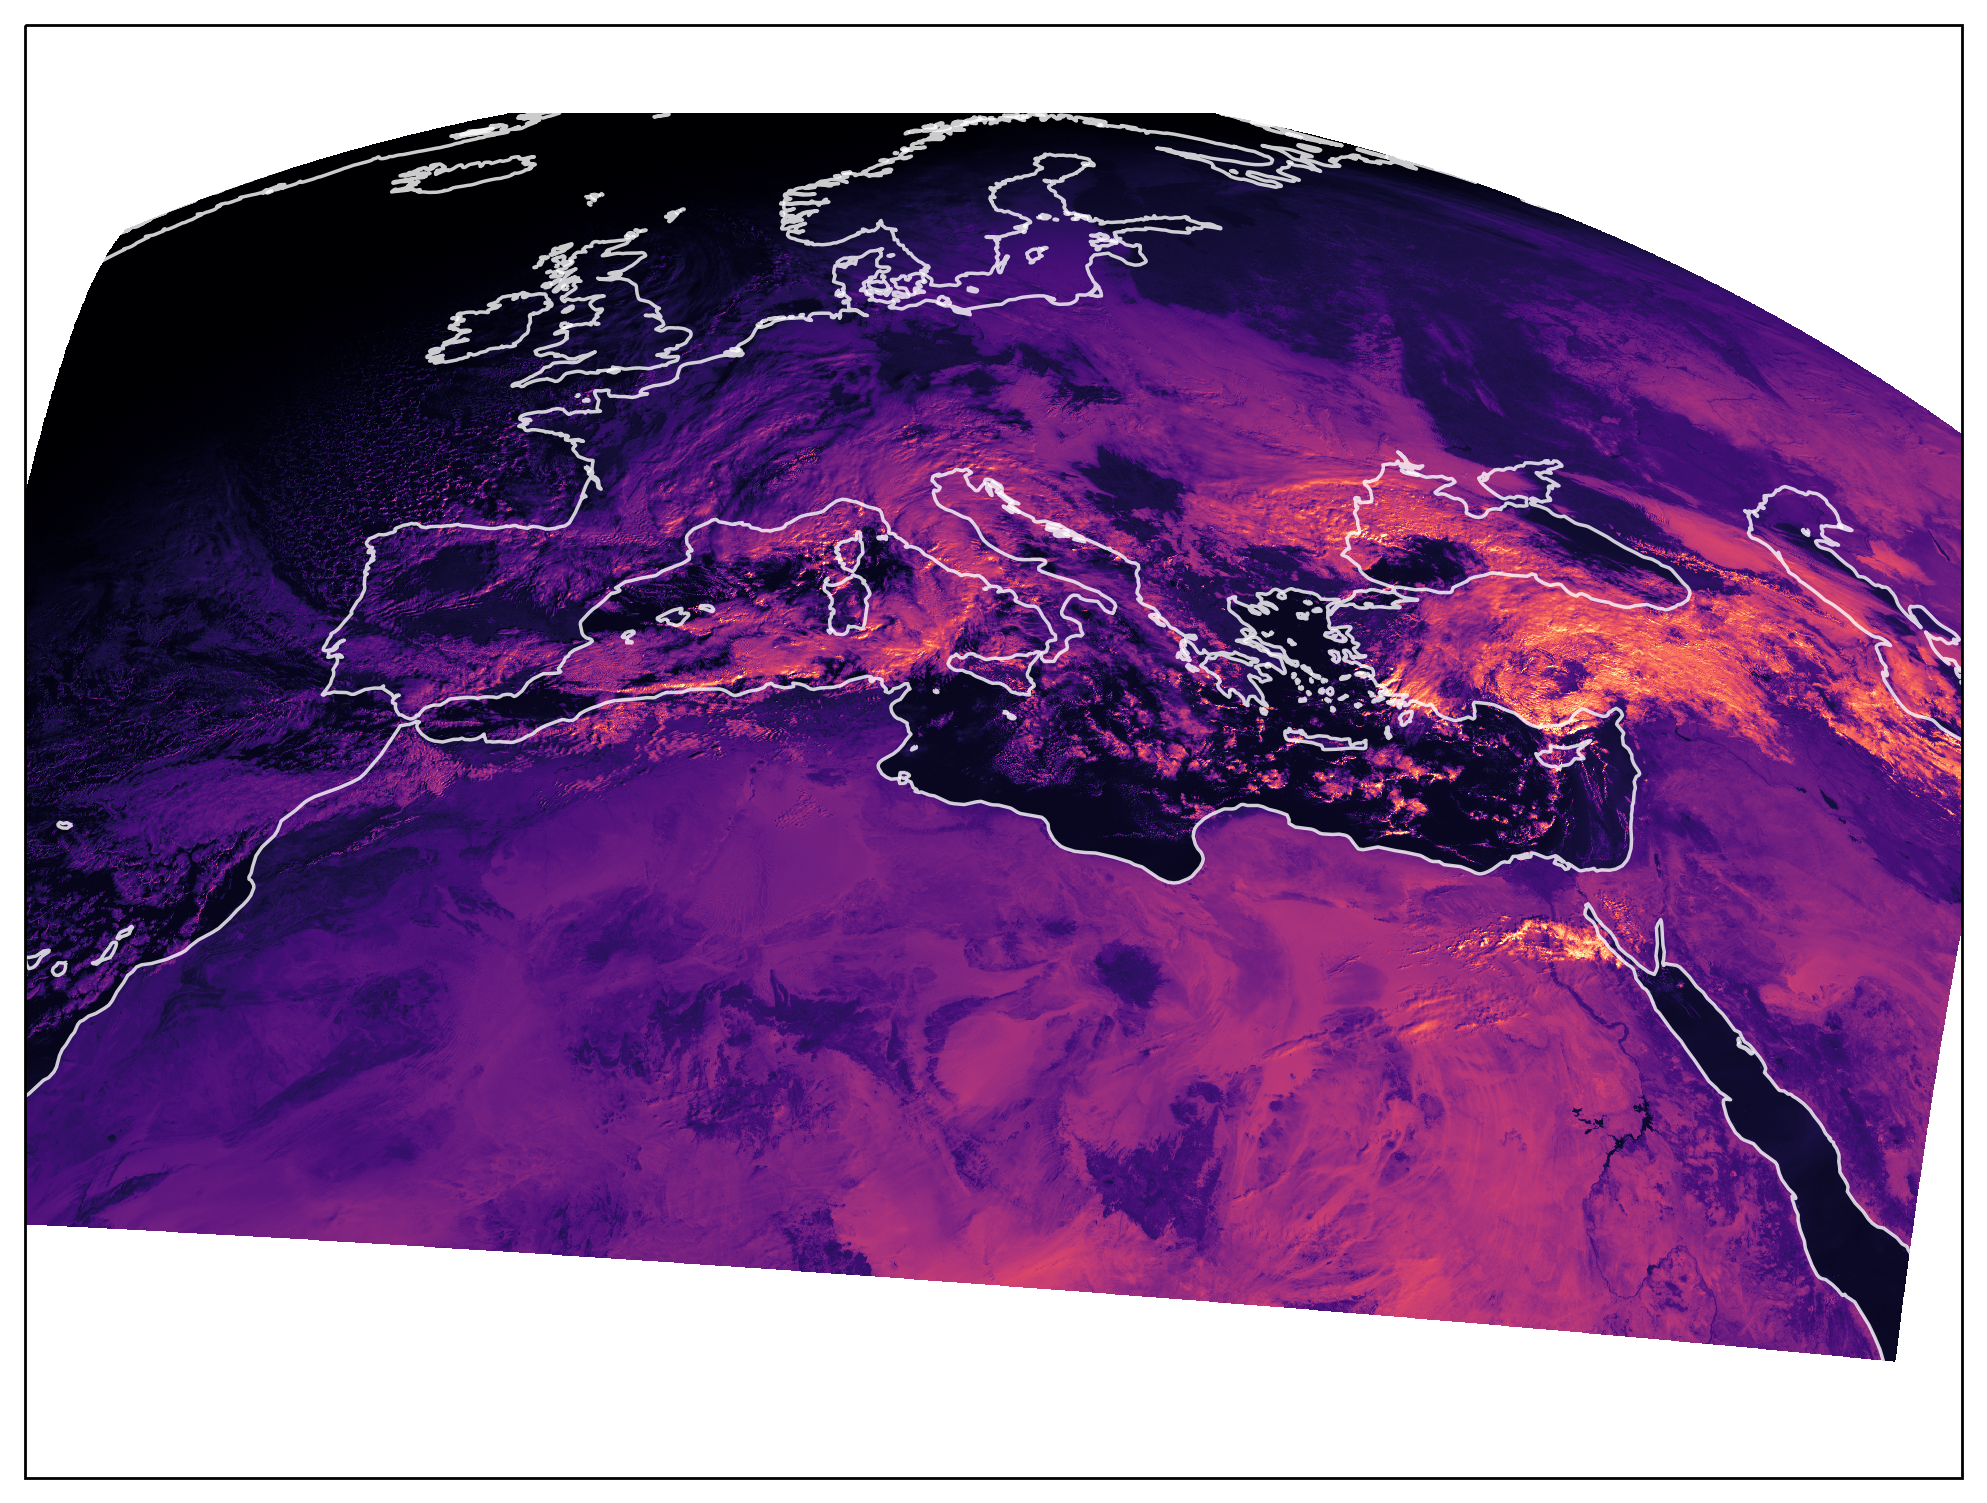

In [12]:
seviri = reproj.get_seviri_area_def(native_fp)
seviri_crs = seviri.to_cartopy_crs()

# Plotting
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=seviri_crs)

scene['HRV'].plot.imshow(ax=ax, add_colorbar=False, cmap='magma', vmin=0, vmax=50)

ax.set_title('')
ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

### Reprojection

The main way to carry out a reprojection is with the `Reprojector` class

In [13]:
reprojector = reproj.Reprojector()

reprojector

<br>

From which the `reproject` method can be called, the default method that will be used is through `pyresample`

In [23]:
%%capture --no-stdout
%%time

ds_reproj = reprojector.reproject(native_fp)

Wall time: 5.58 s


In [24]:
ds_reproj

<xarray.Dataset>
Dimensions:                (variable: 12, x: 1870, y: 1831)
Coordinates:
  * y                      (y) float64 9.012e+06 9.008e+06 ... 1.692e+06
  * x                      (x) float64 -3.088e+06 -3.084e+06 ... 4.388e+06
  * variable               (variable) object 'HRV' 'IR_016' ... 'WV_073'
Data variables:
    stacked_eumetsat_data  (variable, y, x) float32 dask.array<chunksize=(1, 1831, 1870), meta=np.ndarray>

<br>

It's also possible to use the functional api, e.g. for our task we could have used `full_scene_pyresample` to achieve the same results.

In [21]:
%%capture --no-stdout
%%time

ds_reproj = reproj.full_scene_pyresample(native_fp)

Wall time: 4.98 s


In [22]:
ds_reproj

<xarray.Dataset>
Dimensions:                (variable: 12, x: 1870, y: 1831)
Coordinates:
  * y                      (y) float64 9.012e+06 9.008e+06 ... 1.692e+06
  * x                      (x) float64 -3.088e+06 -3.084e+06 ... 4.388e+06
  * variable               (variable) object 'HRV' 'IR_016' ... 'WV_073'
Data variables:
    stacked_eumetsat_data  (variable, y, x) float32 dask.array<chunksize=(1, 1831, 1870), meta=np.ndarray>

<br>

Alongside `pyresample` its also possible to use `pyinterp` which can be faster when the dataset has fewer layers. When using `pyinterp` we have to provide the coordinates of the new grid as well as the coordinates that grid has in the original CRS.

In [28]:
%%capture --no-stdout
%%time

new_coords_fp = f'../data/intermediate/reproj_coords_TM_4km.csv'
new_grid_fp = '../data/intermediate/new_grid_4km_TM.json'

reprojector = reproj.Reprojector(new_coords_fp, new_grid_fp)
ds_reproj = reprojector.reproject(native_fp, reproj_library='pyinterp')

Wall time: 16.5 s


In [29]:
ds_reproj

<xarray.Dataset>
Dimensions:                (variable: 12, x: 1870, y: 1831)
Coordinates:
  * x                      (x) float64 4.388e+06 4.384e+06 ... -3.088e+06
  * y                      (y) float64 1.692e+06 1.696e+06 ... 9.012e+06
  * variable               (variable) object 'HRV' 'IR_016' ... 'WV_073'
Data variables:
    stacked_eumetsat_data  (variable, y, x) float64 nan nan nan ... nan nan nan